In [1]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

# Verificação inicial

In [2]:
DB_PARAMS = {
    'host': 'localhost',
    'port': '5432',
    'database': 'busdata',
    'user': 'user',
    'password': 'pass',
}

DB_URL = f"postgresql://{DB_PARAMS['user']}:{DB_PARAMS['password']}@{DB_PARAMS['host']}:{DB_PARAMS['port']}/{DB_PARAMS['database']}"

engine = create_engine(DB_URL)
with engine.connect() as conn:
    print("Conexão com banco de dados bem-sucedida.")

Conexão com banco de dados bem-sucedida.


primeiro vamos observar os pontos de uma linha de ônibus em um dia para verificar que a conexão está correta

In [3]:
query = """
SELECT ordem, linha, datahoraservidor, velocidade, geom
FROM gps_2024_04_25
WHERE linha = '483'
"""

line_gdf = gpd.read_postgis(query, engine, geom_col='geom', crs="EPSG:4326")
line_gdf['ts'] = pd.to_datetime(line_gdf['datahoraservidor'], unit='ms')


line_gdf.head()

,ordem,linha,datahoraservidor,velocidade,geom,ts
0,B31075,483,1714032030000,22,POINT (-43.28159 -22.83448),2024-04-25 08:00:30
1,B31116,483,1714032153000,0,POINT (-43.27906 -22.82904),2024-04-25 08:02:33
2,B31043,483,1714032153000,48,POINT (-43.17707 -22.95889),2024-04-25 08:02:33
3,B31050,483,1714032153000,0,POINT (-43.3112 -22.80435),2024-04-25 08:02:33
4,B31130,483,1714032153000,0,POINT (-43.30947 -22.80421),2024-04-25 08:02:33


In [4]:
# Print de informações gerais
print("Número de registros:", len(line_gdf))
print("Linhas únicas:", line_gdf['linha'].nunique())
print("Ônibus únicos:", line_gdf['ordem'].nunique())
print("Período:", line_gdf['ts'].min(), "até", line_gdf['ts'].max())

Número de registros: 67625
Linhas únicas: 1
Ônibus únicos: 68
Período: 2024-04-25 08:00:30 até 2024-04-26 02:00:29


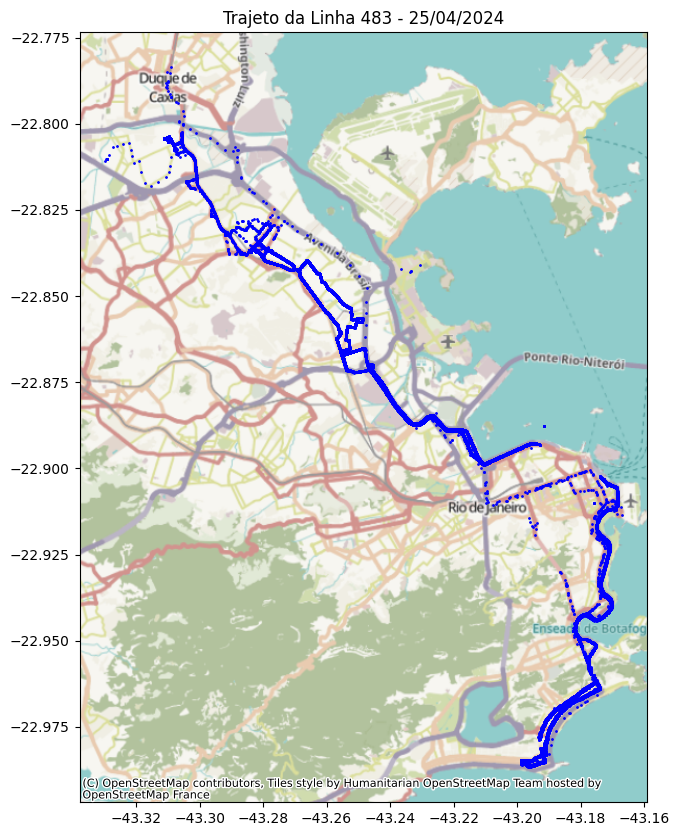

In [21]:
# Plotando o trajeto da linha 483
def plot_gdf(gdf : gpd.GeoDataFrame, title: str):
    """
    Função para plotar um GeoDataFrame com um mapa de fundo.
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame contendo os dados geoespaciais.
        title (str): Título do gráfico.
    """
    ax = gdf.plot(figsize=(12, 10), markersize=1, color='blue')
    ctx.add_basemap(ax, crs=line_gdf.crs)
    plt.title(title)
    plt.show()

plot_gdf(line_gdf, "Trajeto da Linha 483 - 25/04/2024")

## Estimando o trajeto de uma linha

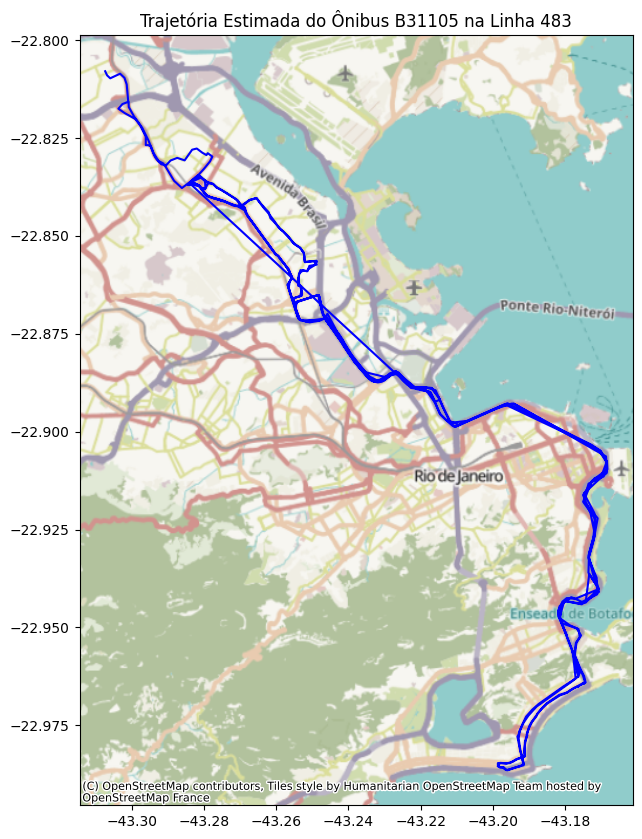

In [22]:
query = """
SELECT *
FROM estimate_bus_trajectory('gps_2024_04_25', '483', 10)
WHERE ordem='B31105'
"""

# A função estimate_bus_trajectory recebe o nome da tabela, o número da linha e a tolerância para a simplificação da linha
# e retorna uma linha estimada da trajetória de cada ônibus (ordem) baseada nos dados da tabela.
trajectory_gdf = gpd.read_postgis(query, engine, geom_col='trajectory', crs="EPSG:4326")

plot_gdf(trajectory_gdf, "Trajetória Estimada do Ônibus B31105 na Linha 483")

Agora misturando isso com as funções criadas no banco para encontrar um buffer da linha

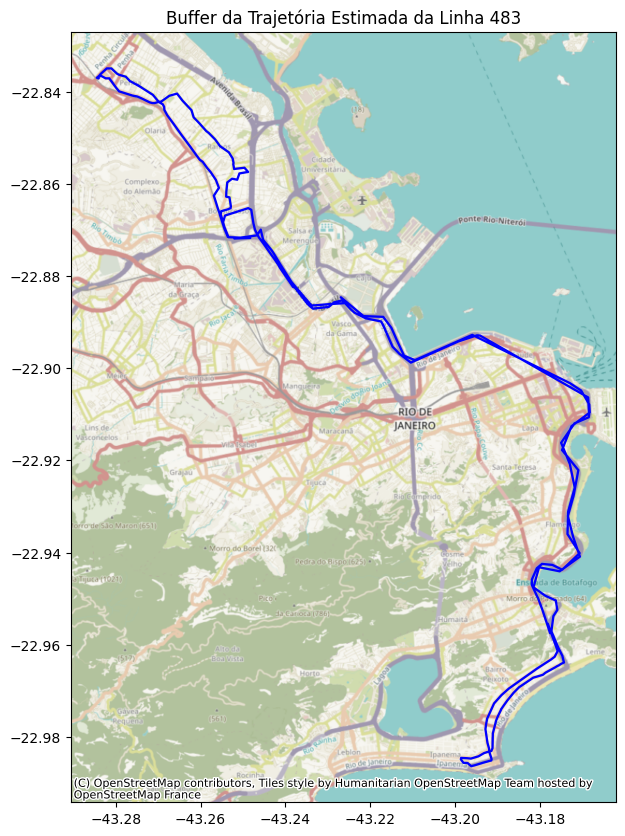

In [28]:
def query_for_buffer(
		table_name : str, 
		bus_line : str, 
		bus_id : int,
		end_pts : tuple[int, int] = (1,2)
	) -> gpd.GeoDataFrame:
	query = f"""
	WITH end_points AS (
		SELECT
			COUNT(*) AS pts_count,
			ST_Centroid(square_geom) AS grid_point
		FROM {table_name}
		INNER JOIN (
			SELECT * FROM make_square_grid('{table_name}', 100)
		)
		ON ST_Intersects(geom, square_geom)
		WHERE linha='{bus_line}'
		GROUP BY square_geom
		ORDER BY pts_count DESC
		LIMIT 50
	), 
	terminals AS (
		SELECT 
			(array_agg(grid_point ORDER BY pts_count DESC))[{end_pts[0]}] AS start_pt,
			(array_agg(grid_point ORDER BY pts_count DESC))[{end_pts[1]}] AS end_pt
		FROM end_points
	),
	bus_line AS (
		SELECT trajectory
		FROM estimate_bus_trajectory('{table_name}', '{bus_line}', 10)
		WHERE ordem='{bus_id}'
	)
	SELECT get_trajectory_buffer(t.start_pt, t.end_pt, b.trajectory, 30) AS trajectory_buffer
	FROM terminals t
	CROSS JOIN bus_line b
	"""

	return gpd.read_postgis(query, engine, geom_col='trajectory_buffer', crs="EPSG:4326")

# Esta consulta utiliza a função get_trajectory_buffer para calcular um buffer de X metros ao longo da trajetória estimada
# para isso ele utiliza as funções auxiliares make_square_grid e get_trajectory_buffer. 
buffer_gdf = query_for_buffer(table_name='gps_2024_04_25', bus_line='483', bus_id='B31105', end_pts=(1, 2))

plot_gdf(buffer_gdf, "Buffer da Trajetória Estimada da Linha 483")

# Populando banco com novos dados

## Trajetos aproximados de cada linha

In [ ]:
# Calcular o buffer de cada linha usando valores ideias
